## Cross-Validation and HyperParameter Tuning for KerasClassifier
Due to the computational expense of running neural networks, this notebook was run on google collab.  To run it it locally, skip the Google Collab Setup Section.  

### Google Collab Setup 
Skip this section if running the notebook locally

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install TensorFlow
!pip install tensorflow

# Install Keras
!pip install keras

!pip install scikeras

!pip install category_encoders

In [1]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import F1Score
from sklearn.neural_network import MLPClassifier

myreload()

#Global Variable for Random State
rs=42 #random_state

#Reload dataframe
df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


### Drop extra columns and encode target
Note we use a function that sets the train and test sets internally

In [5]:
#Drop extra columns and encode target for use in KerasClassifier
df_enc=df.copy(deep=True)
df_enc=df_enc.drop(columns=['billed_amount', 'negotiation_amount', 'offer', 'counter_offer'])
df_enc.decision = df_enc['decision'].map({'Accepted':1, 'Rejected':0})

### Define Scoring Metrics

In [6]:
scoring_metrics_enc = {
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0)
}

### Define function to dynamically create Sequential Networks

In [8]:
def nn_clf(meta, hidden_layer_sizes=(32, 16), activation='relu', l2_reg=0, optimizer='adam', dropout_rate=0.2):
    """
    Create a neural network classifier with configurable parameters.

    Args:
    meta (dict): Metadata containing information about the dataset.
                 Expected keys are 'n_features_in_', 'target_type_', and 'n_classes_' for multiclass targets.
    hidden_layer_sizes (tuple, optional): Sizes of the hidden layers in the neural network. Defaults to (32, 16).
    activation (str, optional): Activation function to use for the hidden layers. Defaults to 'relu'.
    l2_reg (float, optional): L2 regularization factor. Use 0 for no regularization. Defaults to 0.
    optimizer (str, optional): Optimizer to use for compiling the model. Defaults to 'adam'.
    dropout_rate (float, optional): Dropout rate for regularization. Not currently used in the function. Defaults to 0.2.

    Returns:
    model: A compiled Keras Sequential model ready for training.

    Raises:
    NotImplementedError: If the 'target_type_' in meta is not 'binary' or 'multiclass'.

    Note:
    For binary classification, the output layer will have 1 unit with 'sigmoid' activation.
    For multiclass classification, the output layer will have 'n_classes_' units with 'softmax' activation.
    """

    reg = L2(l2_reg) if l2_reg > 0 else None
    model = Sequential()
    model.add(Input(shape=(meta["n_features_in_"])))
    #model.add(Dense(meta["n_features_in_"], activation=activation, kernel_regularizer=reg))

    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense(hidden_layer_size, activation=activation, kernel_regularizer=reg))

    if meta["target_type_"] == "binary":
        n_output_units = 1
        output_activation = "sigmoid"
        loss = "binary_crossentropy"
    elif meta["target_type_"] == "multiclass":
        n_output_units = meta["n_classes_"]
        output_activation = "softmax"
        loss = "sparse_categorical_crossentropy"
    else:
        raise NotImplementedError(f"Unsupported task type: {meta['target_type_']}")

    out = Dense(n_output_units, activation=output_activation)
    model.add(out)
    model.compile(loss=loss, optimizer=optimizer, weighted_metrics=F1Score(threshold=0.5, average='weighted'))
    return model

### Define KerasClassifier with nn_clf and default parameters

In [9]:
krs=KerasClassifier(
        #nn_clf
        model=nn_clf,
        hidden_layer_sizes=(32,16),
        activation='relu',
        l2_reg=0.01,
        dropout_rate=0,
        optimizer='adam', optimizer__learning_rate=0.1,

        #scikeras kerasclassfier
        batch_size=32,
        epochs=100,
        callbacks=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        #class_weight={1: minority_class_weight, 0: 3},
        validation_split=0.2,
        verbose=0,
        random_state=rs,
)

### Set 1 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted
1,0.937007,Yes,0.952038,0.924968,27.683867,0.944987,relu,128,,0.400000,64,"(64, 32)",0.010000,0.100000,180,0.500000,0.000027,0,4
2,0.934849,Yes,0.951858,0.933403,23.066804,0.947135,relu,512,,0.300000,64,"(64, 32, 16)",0.010000,0.100000,228,0.475000,0.000010,0.002500,1


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted,holdout_rank_f1_weighted
2,0.934849,Yes,0.951858,0.933403,23.066804,0.947135,relu,512,<keras.src.callbacks.EarlyStopping object at 0x7df90d42a080>,0.3,64,"(64, 32, 16)",0.01,0.1,228,0.475,0.00001,0.0025,1,1
7,0.931465,Yes,0.962413,0.933187,18.619852,0.941105,relu,256,<keras.src.callbacks.EarlyStopping object at 0x7df90d42a080>,0.4,256,"(64, 32)",0.001,0.1,147,0.45,0.000041,0.005,8,2
3,0.932613,Yes,0.956586,0.930276,16.349761,0.943657,relu,1024,<keras.src.callbacks.EarlyStopping object at 0x7df90d42a890>,0.4,64,"(64, 32)",0.001,0.0001,198,0.425,0.000001,0.005,6,3
10,0.930343,Yes,0.947185,0.928676,23.637136,0.944417,relu,1024,<keras.src.callbacks.EarlyStopping object at 0x7df90d42a080>,0.5,128,"(64, 32, 16)",0.01,0.1,297,0.425,0.000002,0.0065,5,4
4,0.932308,Yes,0.969886,0.927443,25.639108,0.941472,relu,1024,<keras.src.callbacks.EarlyStopping object at 0x7df90d42a080>,0.5,256,"(64, 32)",0.001,0.0001,242,0.425,0.000002,0.0035,7,5


No non-overfit models were found. Consider re-running the function with a houldout_threshold > 0


<Figure size 640x480 with 0 Axes>

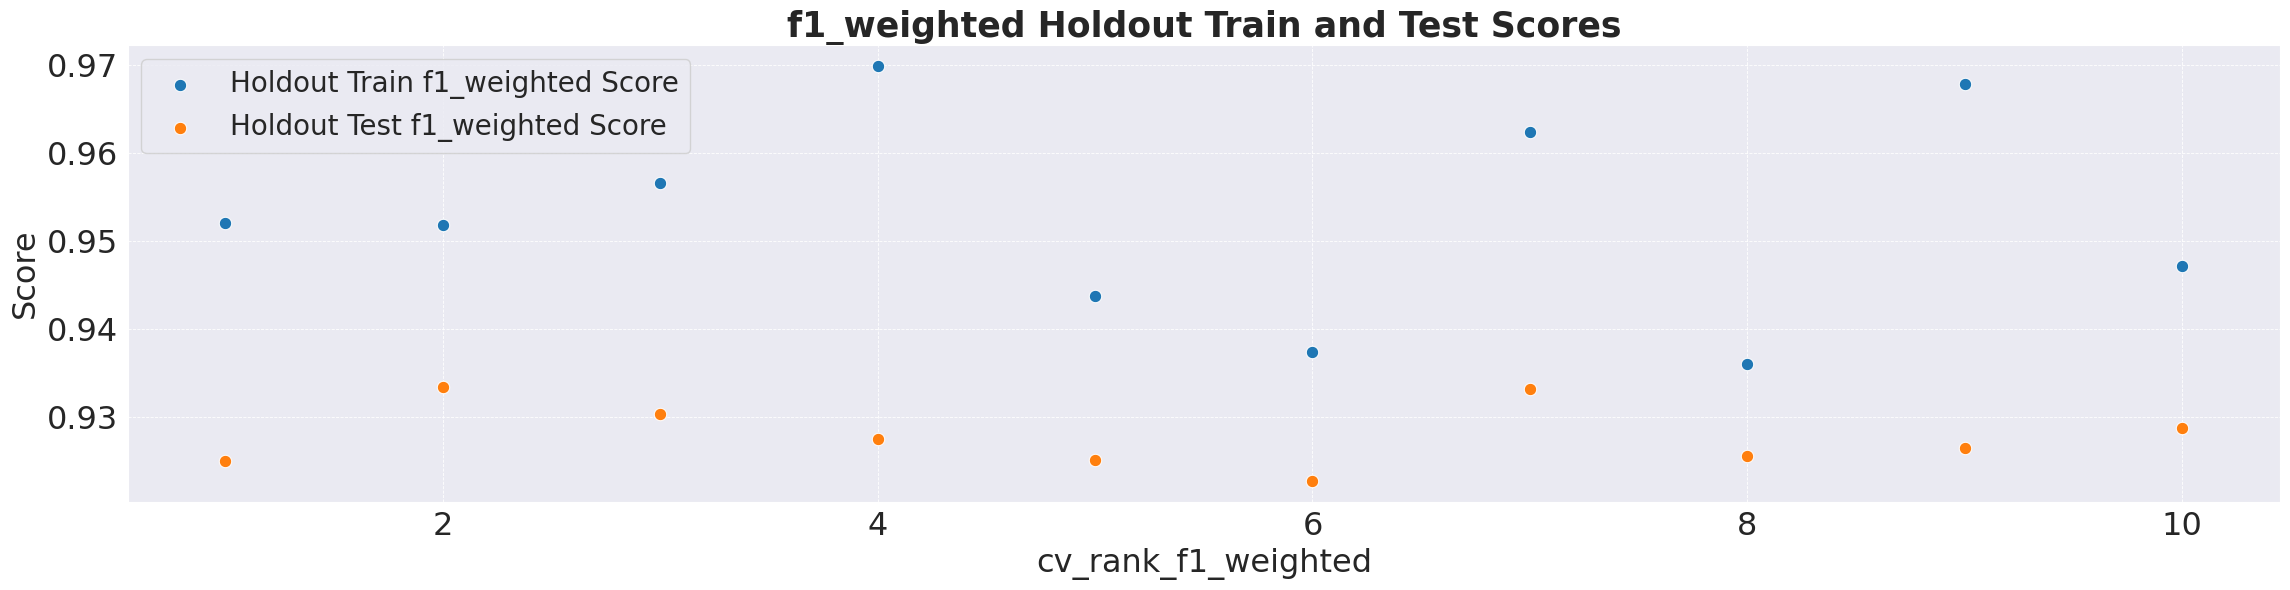

In [10]:

tools.build_and_run_pipes (df_enc,'decision', search_type='random', scoring_metrics = scoring_metrics_enc,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')),
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),
    poly=('poly', PolynomialFeatures(degree=2, include_bias=False)),
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer',
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'],

    cat_combiner=('combiner', xfrs.RareCategoryCombiner()),
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.0035, 0.005, 0.0065, 0.0075]},

    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],

    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ],
    ord_cols=['level'],

    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)},
    undersampler= ('under',RandomUnderSampler(random_state=rs)),

    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 6e-5) },
    estimator_dicts = [{
        'est_tuple': ('krs', krs),
        'est_params': {
        #nn_clf
        'hidden_layer_sizes': [(64, 32, 16), (64,32)],
        'activation': ['relu', 'tanh'],
        'l2_reg': [0.001, 0.01],
        'dropout_rate': [0.3, 0.4, 0.5],
        'optimizer__learning_rate': [0.0001, 0.001, 0.01, 0.1],

        #kerasclassifier
        'batch_size': [128, 256, 512, 1024],
        #'class_weight': class_weights,
        'epochs': [64, 128, 256],
        'callbacks': [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                      EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]}, },],
    set_name= 'ht_krs_set1', cv=3, n_iter=10, summary=True, verbose=1, test_size=0.25, stratify=None,rs=42, n_jobs=1)

### Add Learning Rate Scheduler to callbacks
This will reduce overfitting by reducing the learning when the validation loss stops dropping

In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

early_stopper = EarlyStopping(monitor='val_loss',
                              patience=5,  # Adjusted based on your training behavior
                              min_delta=0.001,  # Minimum change to qualify as an improvement
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # New learning rate = factor * current learning rate
                              patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
                              min_delta=0.001)

callbacks = [early_stopper,  reduce_lr]

### Set 2: include learning rate schedule and reduce hidden layer sizes

Fitting 3 folds for each of 15 candidates, totalling 45 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted
1,0.937831,Yes,0.948183,0.928656,30.787848,0.946047,relu,128,,0.400000,64,"(20, 10)",0.010000,0.100000,180,0.500000,0.000027,0,3
2,0.935275,Yes,0.942231,0.924375,35.419811,0.946994,tanh,512,,0.400000,256,"(20, 10)",0.001000,0.100000,194,0.475000,0.000011,0.003500,1


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted,holdout_rank_f1_weighted
8,0.931513,Yes,0.956471,0.928756,20.857692,0.942857,relu,1024,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.5,256,"(20, 10)",0.001,0.0001,242,0.425,0.000002,0.0035,9,1
1,0.937831,Yes,0.948183,0.928656,30.787848,0.946047,relu,128,<keras.src.callbacks.ReduceLROnPlateau object at 0x7df90422b580>,0.4,64,"(20, 10)",0.01,0.1,180,0.5,0.000027,0,3,2
10,0.929956,Yes,0.957381,0.927492,17.404115,0.941082,relu,256,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.4,64,"(20, 10)",0.001,0.0001,211,0.475,0.000004,0.0075,10,3
6,0.931628,Yes,0.938954,0.926706,20.191366,0.946201,relu,512,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.3,64,"(20, 15, 5)",0.01,0.1,228,0.475,0.00001,0.0025,2,4
9,0.931507,Yes,0.937725,0.924843,23.632826,0.945531,tanh,1024,<keras.src.callbacks.ReduceLROnPlateau object at 0x7df90422b580>,0.4,128,"(20, 10)",0.01,0.001,143,0.5,0.000053,0.0025,6,5


No non-overfit models were found. Consider re-running the function with a houldout_threshold > 0


<Figure size 640x480 with 0 Axes>

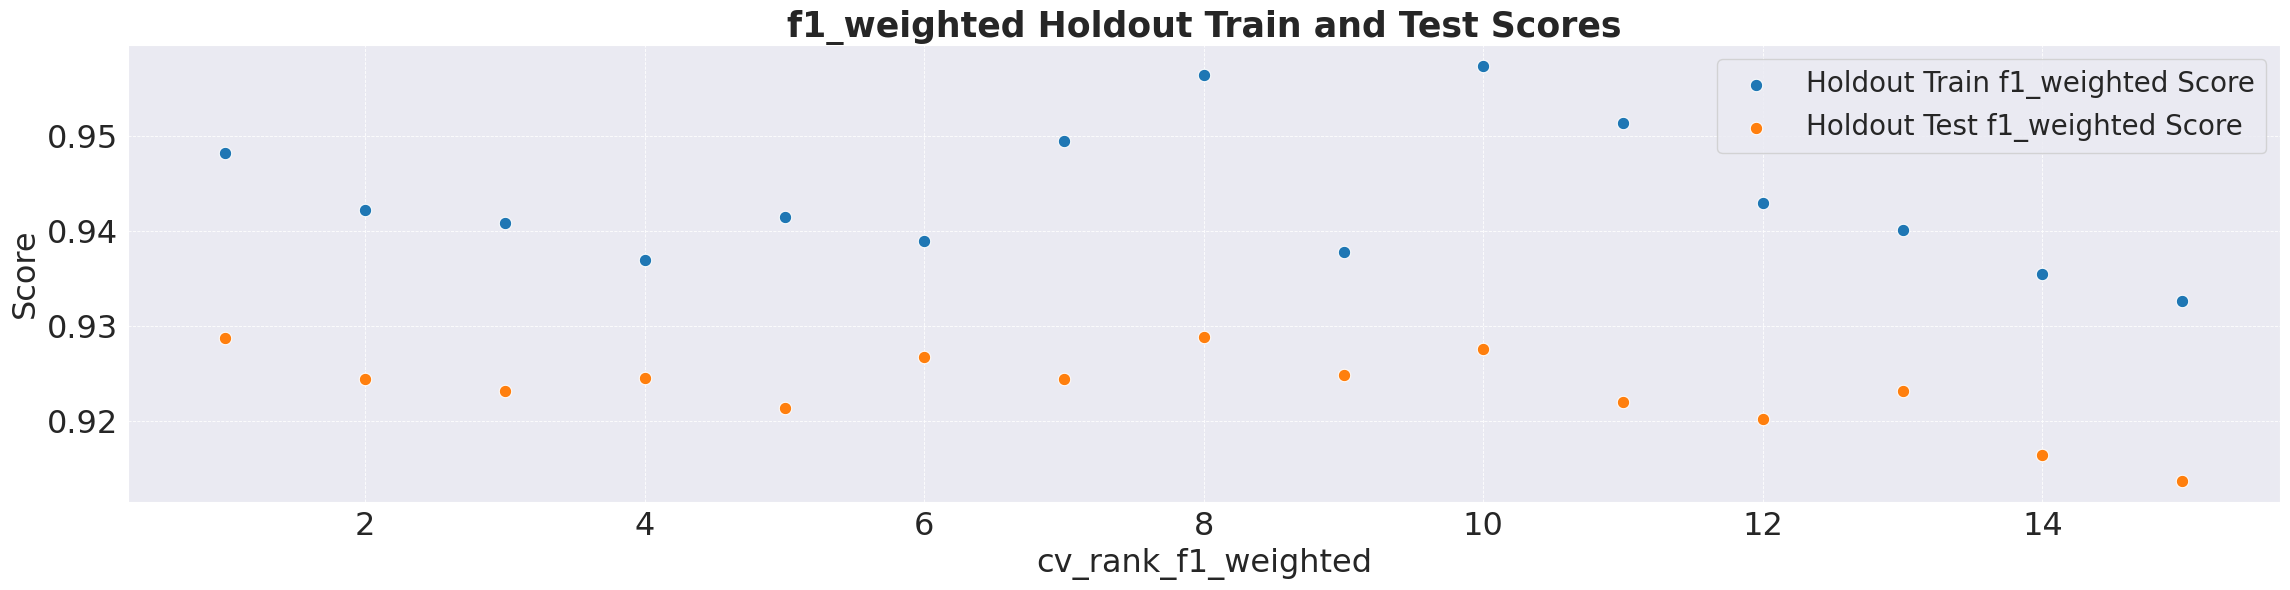

In [12]:

tools.build_and_run_pipes (df_enc,'decision', search_type='random', scoring_metrics = scoring_metrics_enc,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')),
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),
    poly=('poly', PolynomialFeatures(degree=2, include_bias=False)),
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer',
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'],

    cat_combiner=('combiner', xfrs.RareCategoryCombiner()),
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.0035, 0.005, 0.0065, 0.0075]},

    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],

    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ],
    ord_cols=['level'],

    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)},
    undersampler= ('under',RandomUnderSampler(random_state=rs)),

    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 6e-5) },
    estimator_dicts = [{
        'est_tuple': ('krs', krs),
        'est_params': {
        #nn_clf
        'hidden_layer_sizes': [(20, 15, 5), (20,10)],
        'activation': ['relu', 'tanh'],
        'l2_reg': [0.001, 0.01],
        'dropout_rate': [0.3, 0.4, 0.5],
        'optimizer__learning_rate': [0.0001, 0.001, 0.01, 0.1],

        #kerasclassifier
        'batch_size': [128, 256, 512, 1024],
        #'class_weight': class_weights,
        'epochs': [64, 128, 256],
        'callbacks': callbacks, #[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)],
                      }, },],
    set_name= 'ht_krs_set2', cv=3, n_iter=15, summary=True, verbose=1, test_size=0.25, stratify=None,rs=42, n_jobs=1)

#### Set 3 Remove Polynomial Features, reduce layers/dimensions, increase regularization and decrease learning rate and epochs

Fitting 3 folds for each of 15 candidates, totalling 45 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted
1,0.927778,Yes,0.931856,0.918185,12.105751,0.944298,relu,256,,0.300000,100,"(20, 10)",0.092311,0.000010,180,0.500000,0.000027,0,2
2,0.926684,Yes,0.932168,0.917553,9.342964,0.944693,relu,512,,0.300000,100,"(20, 10)",0.010128,0.001000,220,0.450000,0.000025,0.003500,1


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted,holdout_rank_f1_weighted
15,0.849075,No,0.841980,0.859621,6.729704,0.826595,swish,512,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.5,32,"(20, 15, 5)",0.051671,0.00001,144,0.425,0.000003,0.0075,15,1
7,0.923135,Yes,0.935865,0.920308,11.555135,0.942031,swish,256,<keras.src.callbacks.ReduceLROnPlateau object at 0x7df90422b580>,0.5,50,"(20, 15, 5)",0.024125,0.00001,270,0.5,0.000012,0.0065,8,2
4,0.925105,Yes,0.931876,0.918743,12.303980,0.942565,relu,512,<keras.src.callbacks.ReduceLROnPlateau object at 0x7df90422b580>,0.3,100,"(20, 10)",0.064328,0.00001,229,0.5,0.000003,0.005,6,3
1,0.927778,Yes,0.931856,0.918185,12.105751,0.944298,relu,256,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.3,100,"(20, 10)",0.092311,0.00001,180,0.5,0.000027,0,2,4
3,0.926300,Yes,0.929026,0.917992,8.971361,0.942696,tanh,256,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.4,32,"(20, 15, 5)",0.074381,0.0001,214,0.425,0.000002,0,5,5


<Figure size 640x480 with 0 Axes>

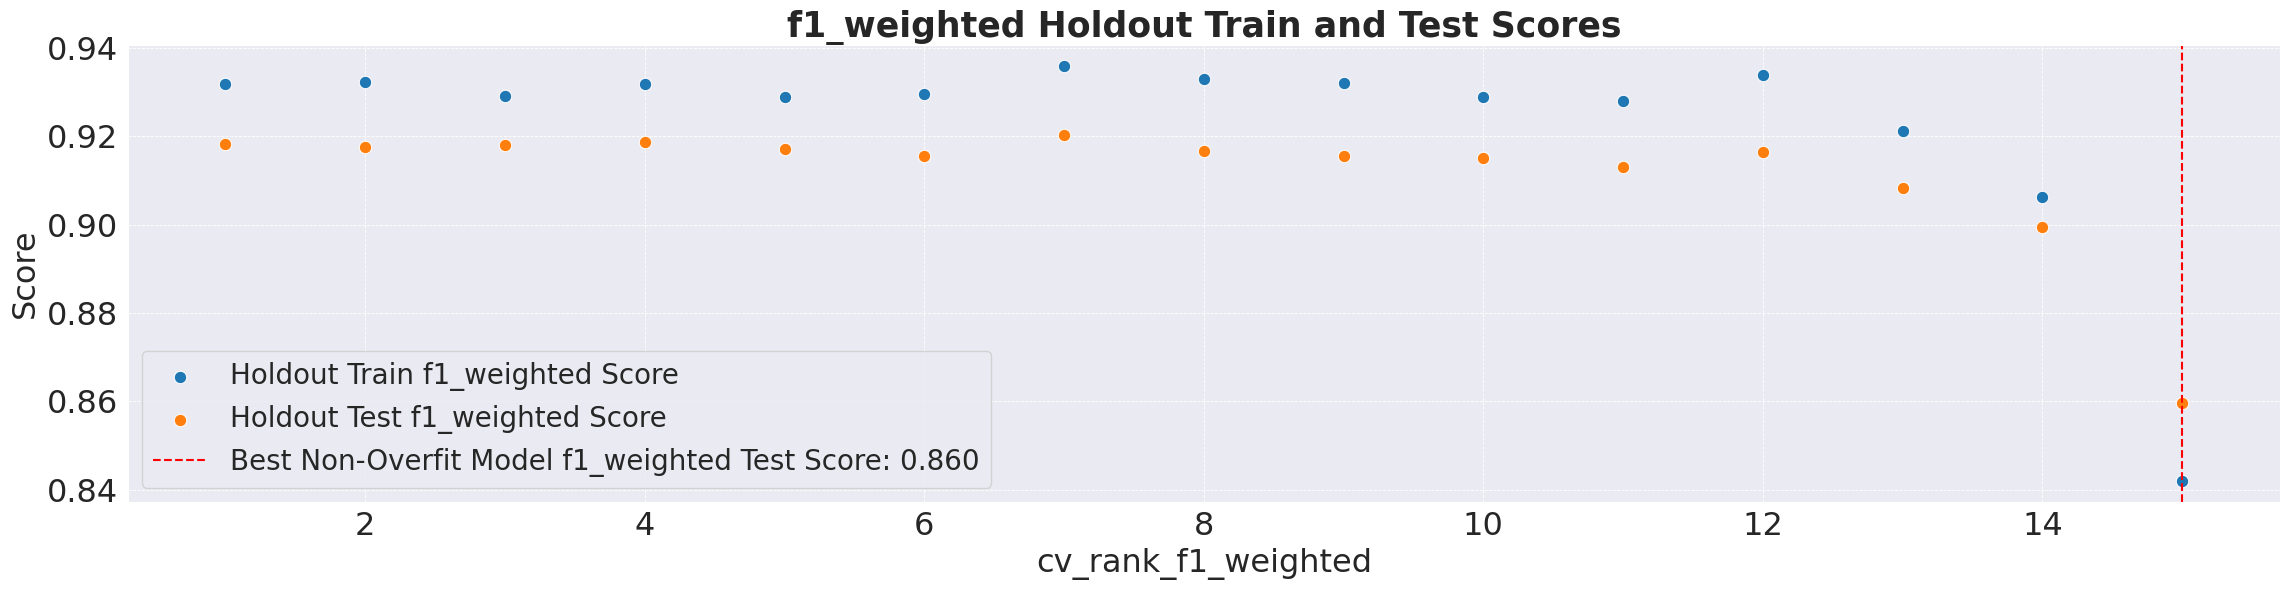

In [17]:
tools.build_and_run_pipes (df_enc,'decision', search_type='random', scoring_metrics = scoring_metrics_enc,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')),
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),
    #poly=('poly', PolynomialFeatures(degree=2, include_bias=False)),
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer',
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'],

    cat_combiner=('combiner', xfrs.RareCategoryCombiner()),
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.0035, 0.005, 0.0065, 0.0075]},

    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],

    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ],
    ord_cols=['level'],

    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)},
    undersampler= ('under',RandomUnderSampler(random_state=rs)),

    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 6e-5) },
    estimator_dicts = [{
        'est_tuple': ('krs', krs),
        'est_params': {
        #nn_clf
        'hidden_layer_sizes': [(20, 15, 5), (20,10)],
        'activation': ['relu', 'tanh', 'swish'],
        'l2_reg': loguniform(1e-2, 1e-1),
        'dropout_rate': [0.3, 0.4, 0.5],
        'optimizer__learning_rate': [0.00001, 0.0001, 0.001],

        #kerasclassifier
        'batch_size': [128, 256, 512, 1024],
        #'class_weight': class_weights,
        'epochs': [32, 50, 64, 100],
        'callbacks': callbacks,
                      }, },],
    set_name= 'ht_krs_set3', cv=3, n_iter=15, summary=True, verbose=1, test_size=0.25, stratify=None,rs=42, n_jobs=1)

### Set 4, Reduce dimensions and epochs even more.  Also increase regularization range

Fitting 3 folds for each of 25 candidates, totalling 75 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted
1,0.930601,Yes,0.937308,0.924843,8.514323,0.945017,swish,128,,0.500000,20,"(10, 10)",0.006624,0.000010,180,0.500000,0.000027,0,2
2,0.929913,Yes,0.938066,0.927921,9.946415,0.943944,tanh,128,,0.500000,32,"(10, 10)",0.004150,0.000050,231,0.400000,0.000004,0,3


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_krs__activation,param_krs__batch_size,param_krs__callbacks,param_krs__dropout_rate,param_krs__epochs,param_krs__hidden_layer_sizes,param_krs__l2_reg,param_krs__optimizer__learning_rate,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted,holdout_rank_f1_weighted
25,0.828813,No,0.890748,0.893945,6.114987,0.871972,tanh,1024,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.5,20,"(10, 10)",0.097445,0.00005,279,0.5,0.00004,0.0035,24,1
2,0.929913,Yes,0.938066,0.927921,9.946415,0.943944,tanh,128,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.5,32,"(10, 10)",0.00415,0.00005,231,0.4,0.000004,0,3,2
1,0.930601,Yes,0.937308,0.924843,8.514323,0.945017,swish,128,<keras.src.callbacks.ReduceLROnPlateau object at 0x7df90422b580>,0.5,20,"(10, 10)",0.006624,0.00001,180,0.5,0.000027,0,2,3
11,0.917894,Yes,0.935849,0.923450,7.131121,0.937601,tanh,256,<keras.src.callbacks.ReduceLROnPlateau object at 0x7df90422b580>,0.5,32,"(10, 10)",0.000359,0.0001,285,0.425,0.000006,0.0025,12,4
12,0.917438,Yes,0.937204,0.922888,6.950226,0.938035,relu,128,<keras.src.callbacks.EarlyStopping object at 0x7df873ef2c50>,0.5,20,"(10, 10)",0.001142,0.0001,242,0.45,0.000006,0.0065,11,5


<Figure size 640x480 with 0 Axes>

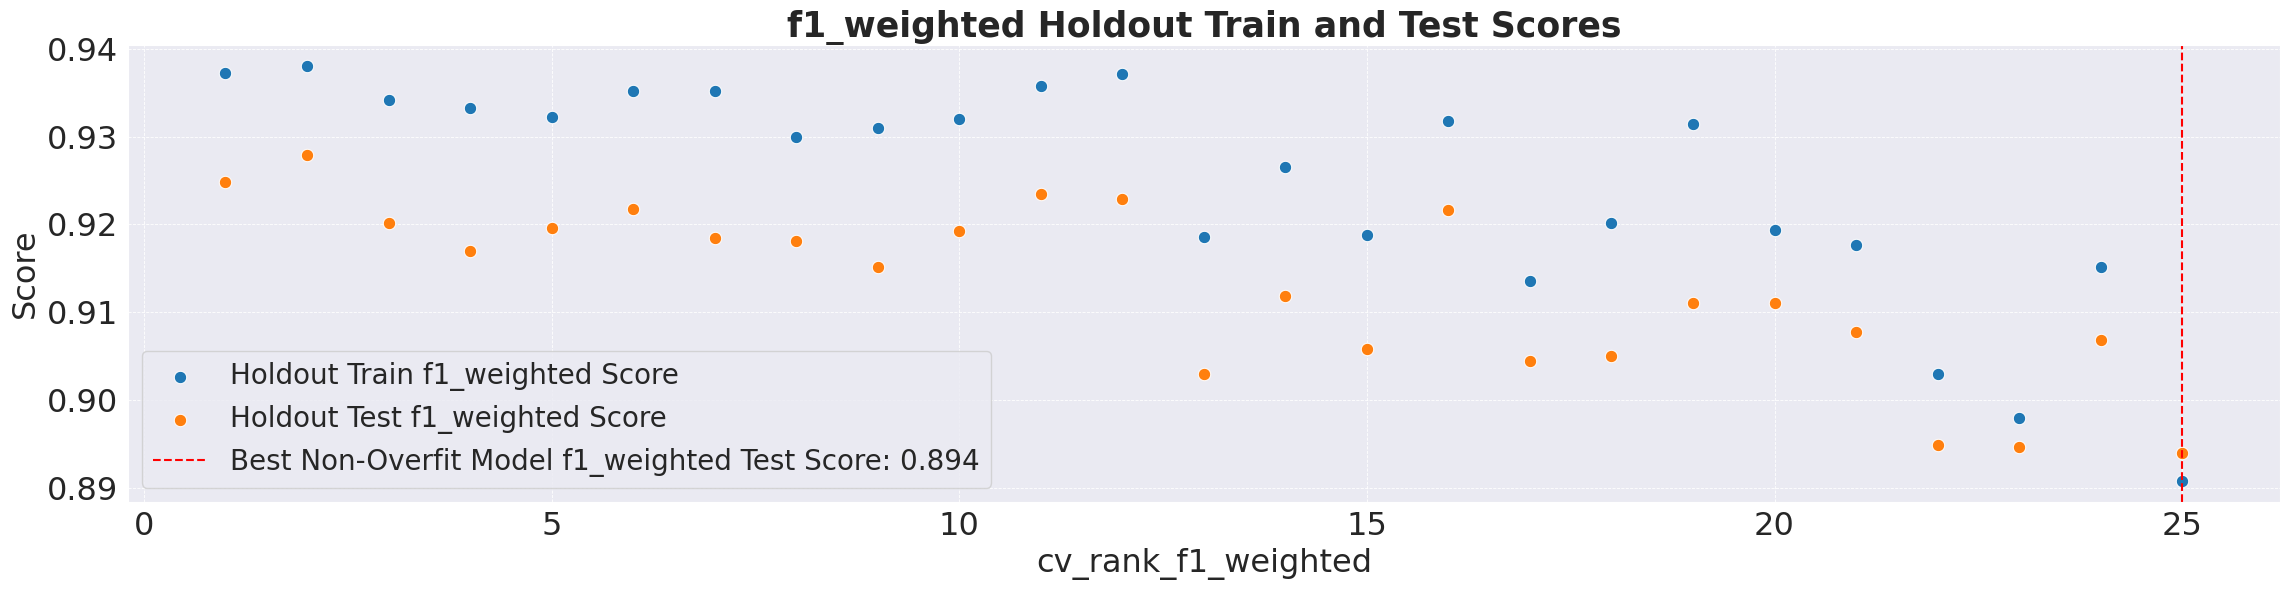

In [19]:
tools.build_and_run_pipes (df_enc,'decision', search_type='random', scoring_metrics = scoring_metrics_enc,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')),
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),
    #poly=('poly', PolynomialFeatures(degree=2, include_bias=False)),
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer',
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'],

    cat_combiner=('combiner', xfrs.RareCategoryCombiner()),
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.0035, 0.005, 0.0065, 0.0075]},

    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],

    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ],
    ord_cols=['level'],

    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)},
    undersampler= ('under',RandomUnderSampler(random_state=rs)),

    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 6e-5) },
    estimator_dicts = [{
        'est_tuple': ('krs', krs),
        'est_params': {
        #nn_clf
        'hidden_layer_sizes': [(15, 10), (10, 10)],
        'activation': ['relu', 'tanh', 'swish'],
        'l2_reg': loguniform(1e-4, 1e-1),
        'dropout_rate': [0.4, 0.5],
        'optimizer__learning_rate': [0.00001, 0.00005, 0.0001, 0.0005],

        #kerasclassifier
        'batch_size': [128, 256, 512, 1024],
        #'class_weight': class_weights,
        'epochs': [20, 32, 50],
        'callbacks': callbacks,
                      }, },],
    set_name= 'ht_krs_set4', cv=3, n_iter=25, summary=True, verbose=1, test_size=0.25, stratify=None,rs=42, n_jobs=1)

### Summary of Findings for Cross-Validation with Hyperparameter Tuning
- In sets 3 and 4, we finally were able to find models that are not overfit, even though this was at the cost of a reduction in score.  The best non-overfit f1 weighted score was from set 4 and was 0.894.
- To arrive at this model, we did a compbination of reducing the number of hidden layers and the neurons per layer.  We also increased regularization, dropout rate and batch size while decreaseing the learning rate and the number of epochs and introduced early stopping with a Learning Rate Schedule.
- Next steps would include:
  - Looking into why the F1Score layer was not properly built for sets 3 and 4 only
  - Use class weights parameters to see if this improves performance.  This makes sense since we have an imbalanced dataset.  
- The best model remains our GradientBoostClassifier with a score of 0.9515